Matlab equivalent command

`initmesh` - `generate_mesh` in `dolfin` 


In [5]:
from fenics import *
from dolfin import *
from mshr import *

import matplotlib
#%matplotlib qt
#%matplotlib widget
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 10

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=300)
from scipy import sparse


from mpl_toolkits.mplot3d import Axes3D

# FENICS

In [41]:
N = 100
sqmesh = UnitSquareMesh(N, N+1)
sqmesh.color('facet')
#plot(sqmesh)
#plt.show()
vertices = sqmesh.coordinates()
print(np.shape(vertices))
#plot(sqmesh)
#plt.show()

(10302, 2)


In [31]:
# An example of solving poisson equation and using Paraview to open the result
mesh = UnitCubeMesh(16 , 16 , 16)
V = FunctionSpace(mesh , 'P', 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1.0)
a = inner(grad(u), grad(v)) * dx
L = f * v * dx
bc = DirichletBC(V, 0.0, 'on_boundary')
uh = Function(V)
solve(a == L, uh, bc)

# save solution in XDMF format
file = XDMFFile ('output.xdmf')
file.write(uh, 0)

# Or save solution in ParaView format
file = File ('output.pvd')
file << uh

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [2]:
# Create mesh and define function space
mesh = UnitSquareMesh(8,8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# # Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
#p = plot(u)
#plot(mesh)

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2 =', error_L2)
print('error_max =', error_max)

# Plot
#p.set_cmap('viridis')
#plt.colorbar(p)
#plt.show()

# Plot the surface (kind of)
fig = plt.figure()
ax = fig.gca(projection='3d')
vertices = mesh.coordinates()
vertex_values_u = u.compute_vertex_values(mesh)
x = vertices[:,0]
y = vertices[:,1]
ax.scatter(x,y,vertex_values_u)
plt.show()

error_L2 = 0.008235098073354827
error_max = 1.3322676295501878e-15


FigureCanvasNbAgg()

# Lab 2

In [3]:
# Based on lab 2 script
def assemblor(p, e, t, f, gamma, g):
    n_p = np.shape(p)[0]       # number of nodes
    n_t = np.shape(t)[0]       # number of elements
    n_e = np.shape(e)[0]       # number of boundary edges
    A = sparse.lil_matrix((n_p, n_p))   # allocate stiffnessmatrix
    R = sparse.lil_matrix((n_p, n_p))   # allocate Robin mass matrix
    b = np.zeros(n_p)          # load vector
    r = np.zeros(n_p)          # Robin load vector
    
    for K in np.arange(n_t):
        loc2glb = t[K]
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        area, bi, ci = HatGradients(x, y)
        AK = (np.outer(bi,bi) + np.outer(ci,ci))*area
        bK = np.array([f(x[0], y[0]),
                       f(x[1], y[1]),
                       f(x[2], y[2])])/3*area
        A[np.ix_(loc2glb, loc2glb)] += AK
        b[np.ix_(loc2glb)] += bK
        
    
    for E in np.arange(n_e):
        loc2glb = e[E]        # local-to-global map
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        z1 = gamma(x, y)
        z2 = g(x, y)
        len = np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)  # edge length
        RE = np.array([[2, 1,],
                       [1, 2]])/6*len*z1    # edge boundary matrix
        
        rE = z1*len*z2/2
        R[np.ix_(loc2glb, loc2glb)] += RE    # Add element masses to R
        r[np.ix_(loc2glb)] += rE
    
    return A, R, b, r

    
def polyArea(x, y):
    v1 = np.array([x[1]-x[0], y[1]-y[0]])
    v2 = np.array([x[2]-x[0], y[2]-y[0]])
    area = 1/2 * np.linalg.norm(np.cross(v1, v2))
    return area


def HatGradients(x, y):
    ''' Returns the area, b, and c
        Grad(ph_i) = transpose([b_i, c_i])
    '''
    area = polyArea(x, y);
    b = np.array([y[1]-y[2], y[2]-y[0], y[0]-y[1]])/2/area
    c = np.array([x[2]-x[1], x[0]-x[2], x[1]-x[0]])/2/area
    return area, b, c
    

## Problem 2 Stiffness matrix of the reference triangle

In [4]:
x = [0, 1, 0]
y = [0, 0, 1]
area, bi, ci = HatGradients(x, y)
AK = (np.outer(bi,bi) + np.outer(ci,ci))*area
AK

array([[ 1. , -0.5, -0.5],
       [-0.5,  0.5,  0. ],
       [-0.5,  0. ,  0.5]])

## Problem 3

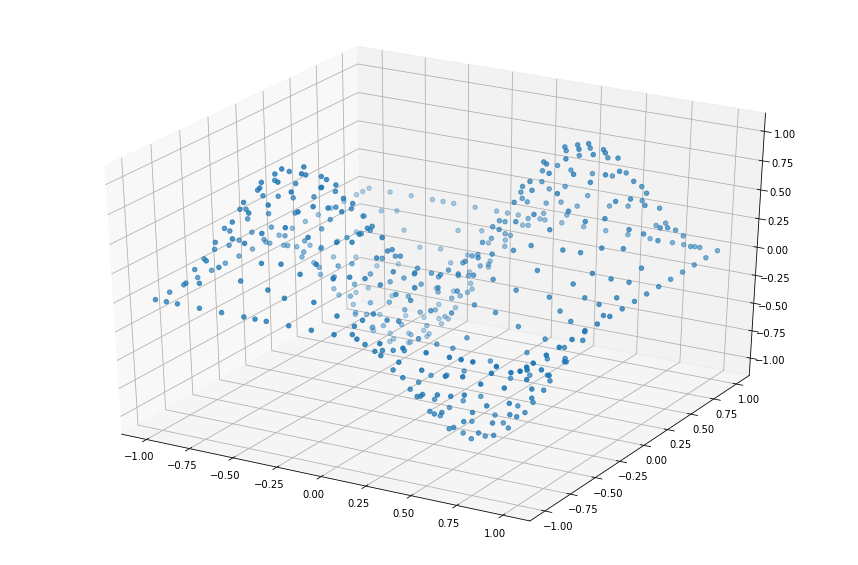

In [6]:
def f(x, y):
    return 2 * np.pi**2 * np.sin(np.pi*x) * np.sin(np.pi*y)

def gamma(x, y):
    return 1e6


def g(x, y):
    return 0

resolution = 15
poly = Polygon([Point(-1,-1), Point(1,-1), Point(1,1), Point(-1,1), Point(-1,-1)])
mesh = generate_mesh(poly, resolution)
p = mesh.coordinates()

# Obtain the e matrix
e_points = BoundaryMesh(mesh, "exterior", True)
e_indices = e_points.entity_map(0)
e = e_indices.array()
e2 = np.append(e[1:], e[0])
e = np.dstack((e, e2)).squeeze()
t = mesh.cells()

A, R, b, r = assemblor(p, e, t, f, gamma, g)
u = np.linalg.solve(A.todense()+R.todense(), b+r)
fig = plt.figure()
ax = fig.gca(projection='3d')
x = p[:,0]
y = p[:,1]
ax.scatter(x,y,u)
plt.show()

In [10]:
# The square of the norm of the gradient of the analytical solution: 
print(np.pi**2 * 2)

# The squre of the norm of the gradient of the numerical solution for hmax=0.151:

print(u.T@A@u)

19.739208802178716
20.048264459504104


In [13]:
# Calculating the error as a function of mesh size

resolutions = [4, 8, 16, 32, 64]
hs = []
errors = []

for i in range(len(resolutions)):
    resolution = resolutions[i]
    poly = Polygon([Point(-1,-1), Point(1,-1), Point(1,1), Point(-1,1), Point(-1,-1)])
    mesh = generate_mesh(poly, resolution)
    p = mesh.coordinates()

    # Obtain the e matrix
    e_points = BoundaryMesh(mesh, "exterior", True)
    e_indices = e_points.entity_map(0)
    e = e_indices.array()
    e2 = np.append(e[1:], e[0])
    e = np.dstack((e, e2)).squeeze()
    t = mesh.cells()

    A, R, b, r = assemblor(p, e, t, f, gamma, g)
    u = np.linalg.solve(A.todense()+R.todense(), b+r)
    
    hmax = mesh.hmax()
    hs.append(hmax)
    error = np.pi**2 * 2 - u.T@A@u
    errors.append(error)
    
print(errors)


[-4.599228070001452, -1.126087398962838, -0.24559249991426668, -0.05850216827283106, -0.015125369722984061]


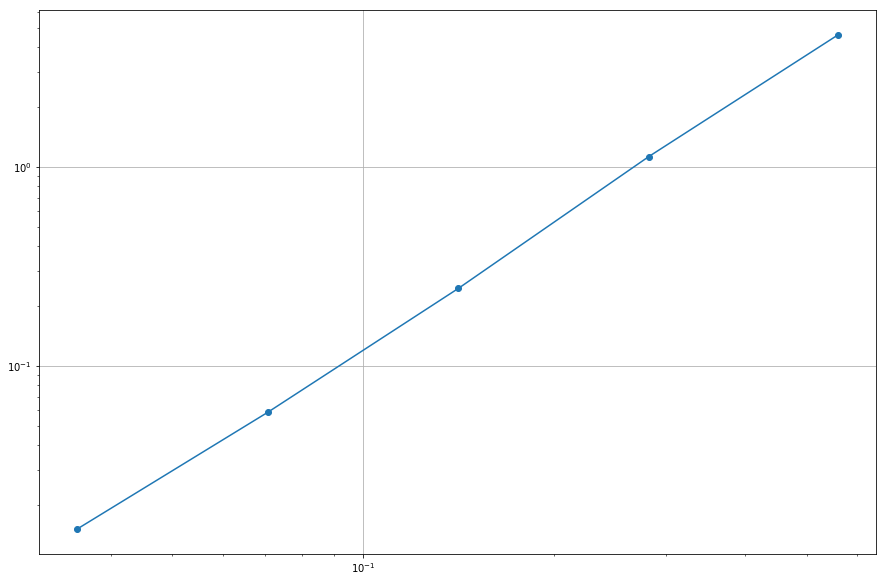

In [22]:
plt.loglog(hs, np.abs(errors), 'o-')
plt.grid()
plt.show()

In [25]:
# Polyfit shows that the slop is about 2
np.polyfit(np.log(hs), np.log(np.abs(errors)), deg=1)

array([2.08470762, 2.72759877])

## Problem 4

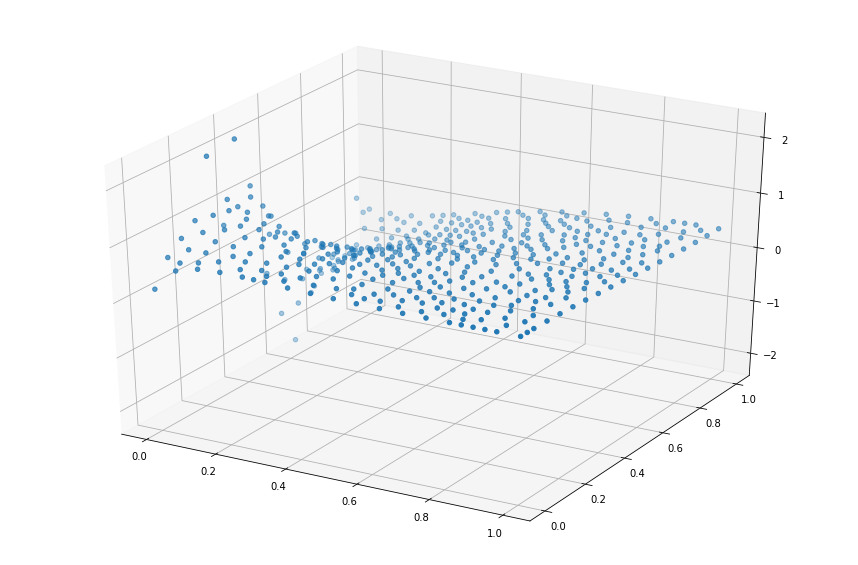

In [12]:
def f(x, y):
    return 1

def gamma(x, y):
    return 1e6 if x.any()==0 else 0

def g(x, y):
    z = 0
    z = np.sin(2*np.pi*y)
    return z

resolution = 15
poly = Polygon([Point(0,0), Point(1,0), Point(1,1), Point(0,1), Point(0,0)])
mesh = generate_mesh(poly, resolution)
p = mesh.coordinates()

# Obtain the e matrix
e_points = BoundaryMesh(mesh, "exterior", True)
e_indices = e_points.entity_map(0)
e = e_indices.array()
e2 = np.append(e[1:], e[0])
e = np.dstack((e, e2)).squeeze()
t = mesh.cells()

A, R, b, r = assemblor(p, e, t, f, gamma, g)
u = np.linalg.solve(A.todense()+R.todense(), b+r)
fig = plt.figure()
ax = fig.gca(projection='3d')
x = p[:,0]
y = p[:,1]
ax.scatter(x,y,u)
plt.show()

# Examples from textbook

In [10]:
def MassAssembler2D(p, t):
    '''
    input p is mesh.coordinates(), dimension (np, 2)
    input t is mesh.cells(), dimension (nt, 3)
    output M is the mass matrix
    '''
    n_p = np.shape(p)[0]       # number of nodes
    n_t = np.shape(t)[0]       # number of elements
    M = sparse.lil_matrix((n_p, n_p))   # allocate mass matrix
    # M.todense()             # Can show a dense version of the matrix
    for K in np.arange(n_t):   # Loop over elements
        loc2glb = t[K]        # local-to-global map
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        area = polyArea(x, y);               # area of the triangle
        MK = np.array([[2, 1, 1],
                       [1, 2, 1],
                       [1, 1, 2]])/12*area   # element mass matrix
        M[np.ix_(loc2glb, loc2glb)] += MK    # Add element masses to M
        
    return M


def LoadAssembler2D(p, t, f):
    n_p = np.shape(p)[0]       # number of nodes
    n_t = np.shape(t)[0]       # number of boundary edges
    b = np.zeros(n_p)
    for K in np.arange(n_t):
        loc2glb = t[K]
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        area = polyArea(x, y);               # area of the triangle
        bK = np.array([f(x[0], y[0]),
                       f(x[1], y[1]),
                       f(x[2], y[2])])/3*area # element load vector
        b[np.ix_(loc2glb)] += bK
    
    return b


def StiffnessAssembler2D(p, t, a):
    '''
    input p is mesh.coordinates(), dimension (np, 2)
    input t is mesh.cells(), dimension (nt, 3)
    input a is the coefficient function a(x,y)
    output A is the stiffness matrix
    '''
    n_p = np.shape(p)[0]       # number of nodes
    n_t = np.shape(t)[0]       # number of elements
    A = sparse.lil_matrix((n_p, n_p))   # allocate stiffnessmatrix
    for K in np.arange(n_t):
        loc2glb = t[K] 
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        area, b, c = HatGradients(x, y)
        xc = np.mean(x)
        yc = np.mean(y)       # element centroid
        abar = a(xc, yc)      # value of a(x,y) at centroid
        AK = abar*(np.outer(b,b) + np.outer(c,c))*area # element stiffness matrix
        A[np.ix_(loc2glb, loc2glb)] += AK
    
    return A
        
    
def RobinMassMatrix2D(p, e, kappa):
    '''
    input p is mesh.coordinates(), dimension (np, 2)
    input t is mesh.cells(), dimension (nt, 3)
    output R is the Robin mass matrix
    '''
    n_p = np.shape(p)[0]       # number of nodes
    n_e = np.shape(e)[0]       # number of boundary edges
    print(n_e)
    R = sparse.lil_matrix((n_p, n_p))   # allocate Robin mass matrix
    # M.todense()             # Can show a dense version of the matrix
    
    for E in np.arange(n_e):   # Loop over boundary edges
        loc2glb = e[E]        # local-to-global map
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        len = np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)  # edge length
        xc = np.mean(x)
        yc = np.mean(y)       # edge mid-point
        k = kappa(xc, yc)     # value of kappa at mid-point
        RE = np.array([[2, 1,],
                       [1, 2]])*k/6*len    # edge boundary matrix
        R[np.ix_(loc2glb, loc2glb)] += RE    # Add element masses to R
        
    return R
    

def RobinLoadVector2D(p, e, kappa, gD, gN):
    n_p = np.shape(p)[0]       # number of nodes
    n_e = np.shape(e)[0]       # number of boundary edges
    r = np.zeros(n_p)
    for E in np.arange(n_e):
        loc2glb = e[E]        # local-to-global map
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        len = np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)  # edge length
        xc = np.mean(x)
        yc = np.mean(y)       # edge mid-point
        tmp = kappa(xc,yc) * gD(xc,yc) + gN(xc,yc)
        rE = tmp*np.array([1, 1])*len/2
        r[np.ix_(loc2glb)] += rE
    return r


def kappa(x, y):
    return 1

def f(x, y):   # example of f
    return x*y

def gD(x, y):
    return 0

def gN(x, y):
    return 0

In [84]:
# example from the textbook P64 to test the MassAssembler2D function
# Got the same result 
p = np.array([[0,0], [1,0], [2,0], [2,1], [0,1]])
t = np.array([[1,4,5], [1,2,4], [2,3,4]])-1    # -1 to offset the index-difference
M = MassAssembler2D(p, t)
print(M.todense())

[[0.25       0.04166667 0.         0.125      0.08333333]
 [0.04166667 0.16666667 0.04166667 0.08333333 0.        ]
 [0.         0.04166667 0.08333333 0.04166667 0.        ]
 [0.125      0.08333333 0.04166667 0.33333333 0.08333333]
 [0.08333333 0.         0.         0.08333333 0.16666667]]


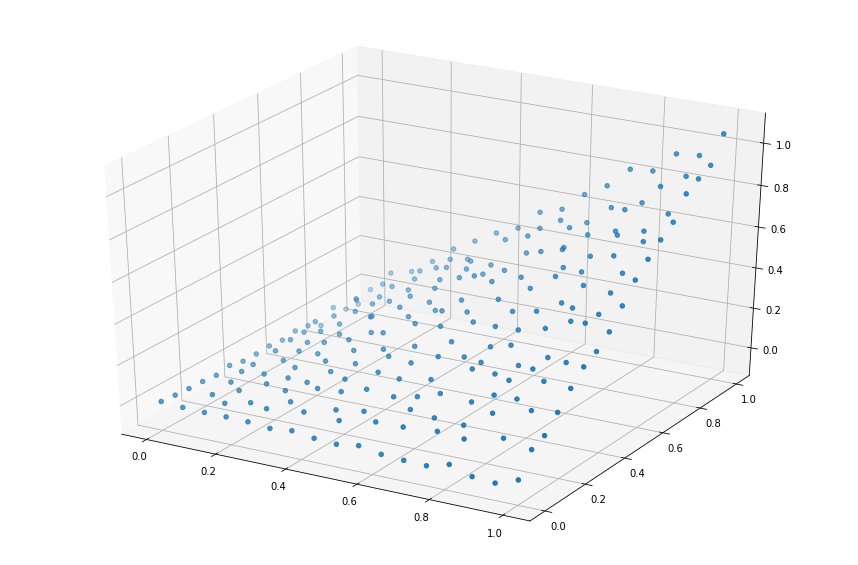

In [11]:
# Example from book Page 66
def L2Projector2D():
    resolution = 10
    poly = Polygon([Point(0,0), Point(1,0), Point(1,1), Point(0,1), Point(0,0)])
    mesh = generate_mesh(poly, resolution)
    #plot(mesh)
    #plt.show()
    p = mesh.coordinates()
    t = mesh.cells()
    M = MassAssembler2D(p, t)
    b = LoadAssembler2D(p, t, f)
    #print(b)
    b_re = b.reshape(-1,1)
    pf = np.linalg.solve(M.todense(), b_re)
    x = p[:,0]
    y = p[:,1]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(x,y,pf)
    plt.show()

L2Projector2D()